In [9]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                 'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                 'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                 'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                 '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                  "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                  'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                  'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                  '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl', 'wdw','disneylandparis',
                  'theme_park', 'min', 'day', 'new', 'guy', 'year', 'way', 'part', 'thing', 'man','ティスニー',
                  'side', 'sia', 'mickey', 'ティスニーラント', 'ティスニーハロウィーン', 'today', 'wanna', 'place',
                  'world', 'disneyworld', 'next'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [10]:
# Import Dataset
df = pd.read_json('DiSmldata.json')
print(df.shape) 
df.head()

(87510, 17)


,hash_count,emoji_count,clean_text,label,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,punc_count,tweet_len,cap_count,user_follower,user_favorite
0,1,0,new mickey flower bed going make event photo l...,2,0,0,0,0,0,0,0,0,9,193,20,1214.0,982.0
2,1,0,thought different yesterday mickey flower bed ...,1,0,1,0,0,0,0,0,0,10,115,13,638.0,195775.0
5,0,0,mickey flower bed renewed tokyo disneyland tod...,1,0,0,0,0,0,0,0,0,12,119,16,157.0,4158.0
17,1,0,mickey flower bed back tdrnow,1,0,0,0,0,0,0,0,0,10,72,12,83.0,8334.0
19,0,0,god has face changed,1,0,1,0,1,1,0,0,1,0,29,3,882.0,41436.0


In [11]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.clean_text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['new', 'mickey', 'flower', 'bed', 'going', 'make', 'event', 'photo', 'location', 'world', 'bazaar', 'side', 'there', 'space', 'mickey', 'side', 'put', 'photo', 'location', 'tdrnow', 'sia']]


In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases. Must show up more than 5 times the phrases 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [13]:
data_ready[0:10]

[['event', 'photo', 'location', 'bazaar', 'space', 'photo', 'location'],
 ['different', 'yesterday'],
 [],
 [],
 ['face'],
 ['hihi_jet', 'dribo', 'rest', 'performance', 'smile', 'friend'],
 ['castle'],
 [],
 ['good', 'common', 'cushion'],
 ['arrive',
  'grandfather',
  'love',
  'picture',
  'guest',
  'costume',
  'person',
  'commemorative',
  'photo',
  'grandfather',
  'inseptember',
  'halloween',
  'time',
  'lot',
  'people',
  'grandfather']]

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [15]:
pprint(lda_model.print_topics())

[(0,
  '0.016*"friend" + 0.016*"christmas" + 0.015*"adventure" + 0.014*"party" + '
  '0.014*"disneyhalloween" + 0.012*"work" + 0.012*"happyhalloween" + '
  '0.011*"disneypark" + 0.010*"resort" + 0.010*"story"'),
 (1,
  '0.022*"trip" + 0.017*"last" + 0.015*"favorite" + 0.014*"lol" + '
  '0.014*"haunted_mansion" + 0.013*"night" + 0.013*"kid" + 0.012*"photo" + '
  '0.012*"cold" + 0.010*"hotel"'),
 (2,
  '0.025*"good" + 0.020*"fun" + 0.016*"hauntedmansion" + 0.014*"great" + '
  '0.013*"holiday" + 0.012*"video" + 0.011*"life" + 0.011*"baby" + '
  '0.010*"cute" + 0.009*"old"'),
 (3,
  '0.126*"halloween" + 0.054*"happy" + 0.053*"time" + 0.020*"love" + '
  '0.020*"park" + 0.018*"ride" + 0.014*"first" + 0.012*"little" + 0.011*"girl" '
  '+ 0.010*"week"')]


In [16]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.6172,"trip, last, favorite, lol, haunted_mansion, ni...","[event, photo, location, bazaar, space, photo,..."
1,1,3.0,0.7500,"halloween, happy, time, love, park, ride, firs...","[different, yesterday]"
2,2,0.0,0.2500,"friend, christmas, adventure, party, disneyhal...",[]
3,3,0.0,0.2500,"friend, christmas, adventure, party, disneyhal...",[]
4,4,3.0,0.6250,"halloween, happy, time, love, park, ride, firs...",[face]


In [17]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9511,"friend, christmas, adventure, party, disneyhalloween, work, happyhalloween, disneypark, resort, ...","[miki, hiro, mikisama, フェスティハルオフミスティーク, 東京ティスニーシー, ミキ広, ティスニーシー, ミキミニ, ミッキーマウス, ミキミニ, ミキミニ, ホルトハ..."
1,1.0,0.9643,"trip, last, favorite, lol, haunted_mansion, night, kid, photo, cold, hotel","[yabai_yabai, yabai_yabai, yaba, iya, yaba, iyaya, yaba, iyaya, yaba_yaba, yaba_yabai, yaba_yaba..."
2,2.0,0.9421,"good, fun, hauntedmansion, great, holiday, video, life, baby, cute, old","[tomorrow, tomorrow, tomorrow, tomorrow, tomorrow, something, tomorrow, twitter, insta, 石川瑛一朗, 國..."
3,3.0,0.9434,"halloween, happy, time, love, park, ride, first, little, girl, week","[weibo, happy, halloween, happy, halloween, 鞠婧祎, jujingyi, 鞠婧禕, kikuchanj, kiku, 쥐징이, キクちゃん, cuc..."


In [18]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

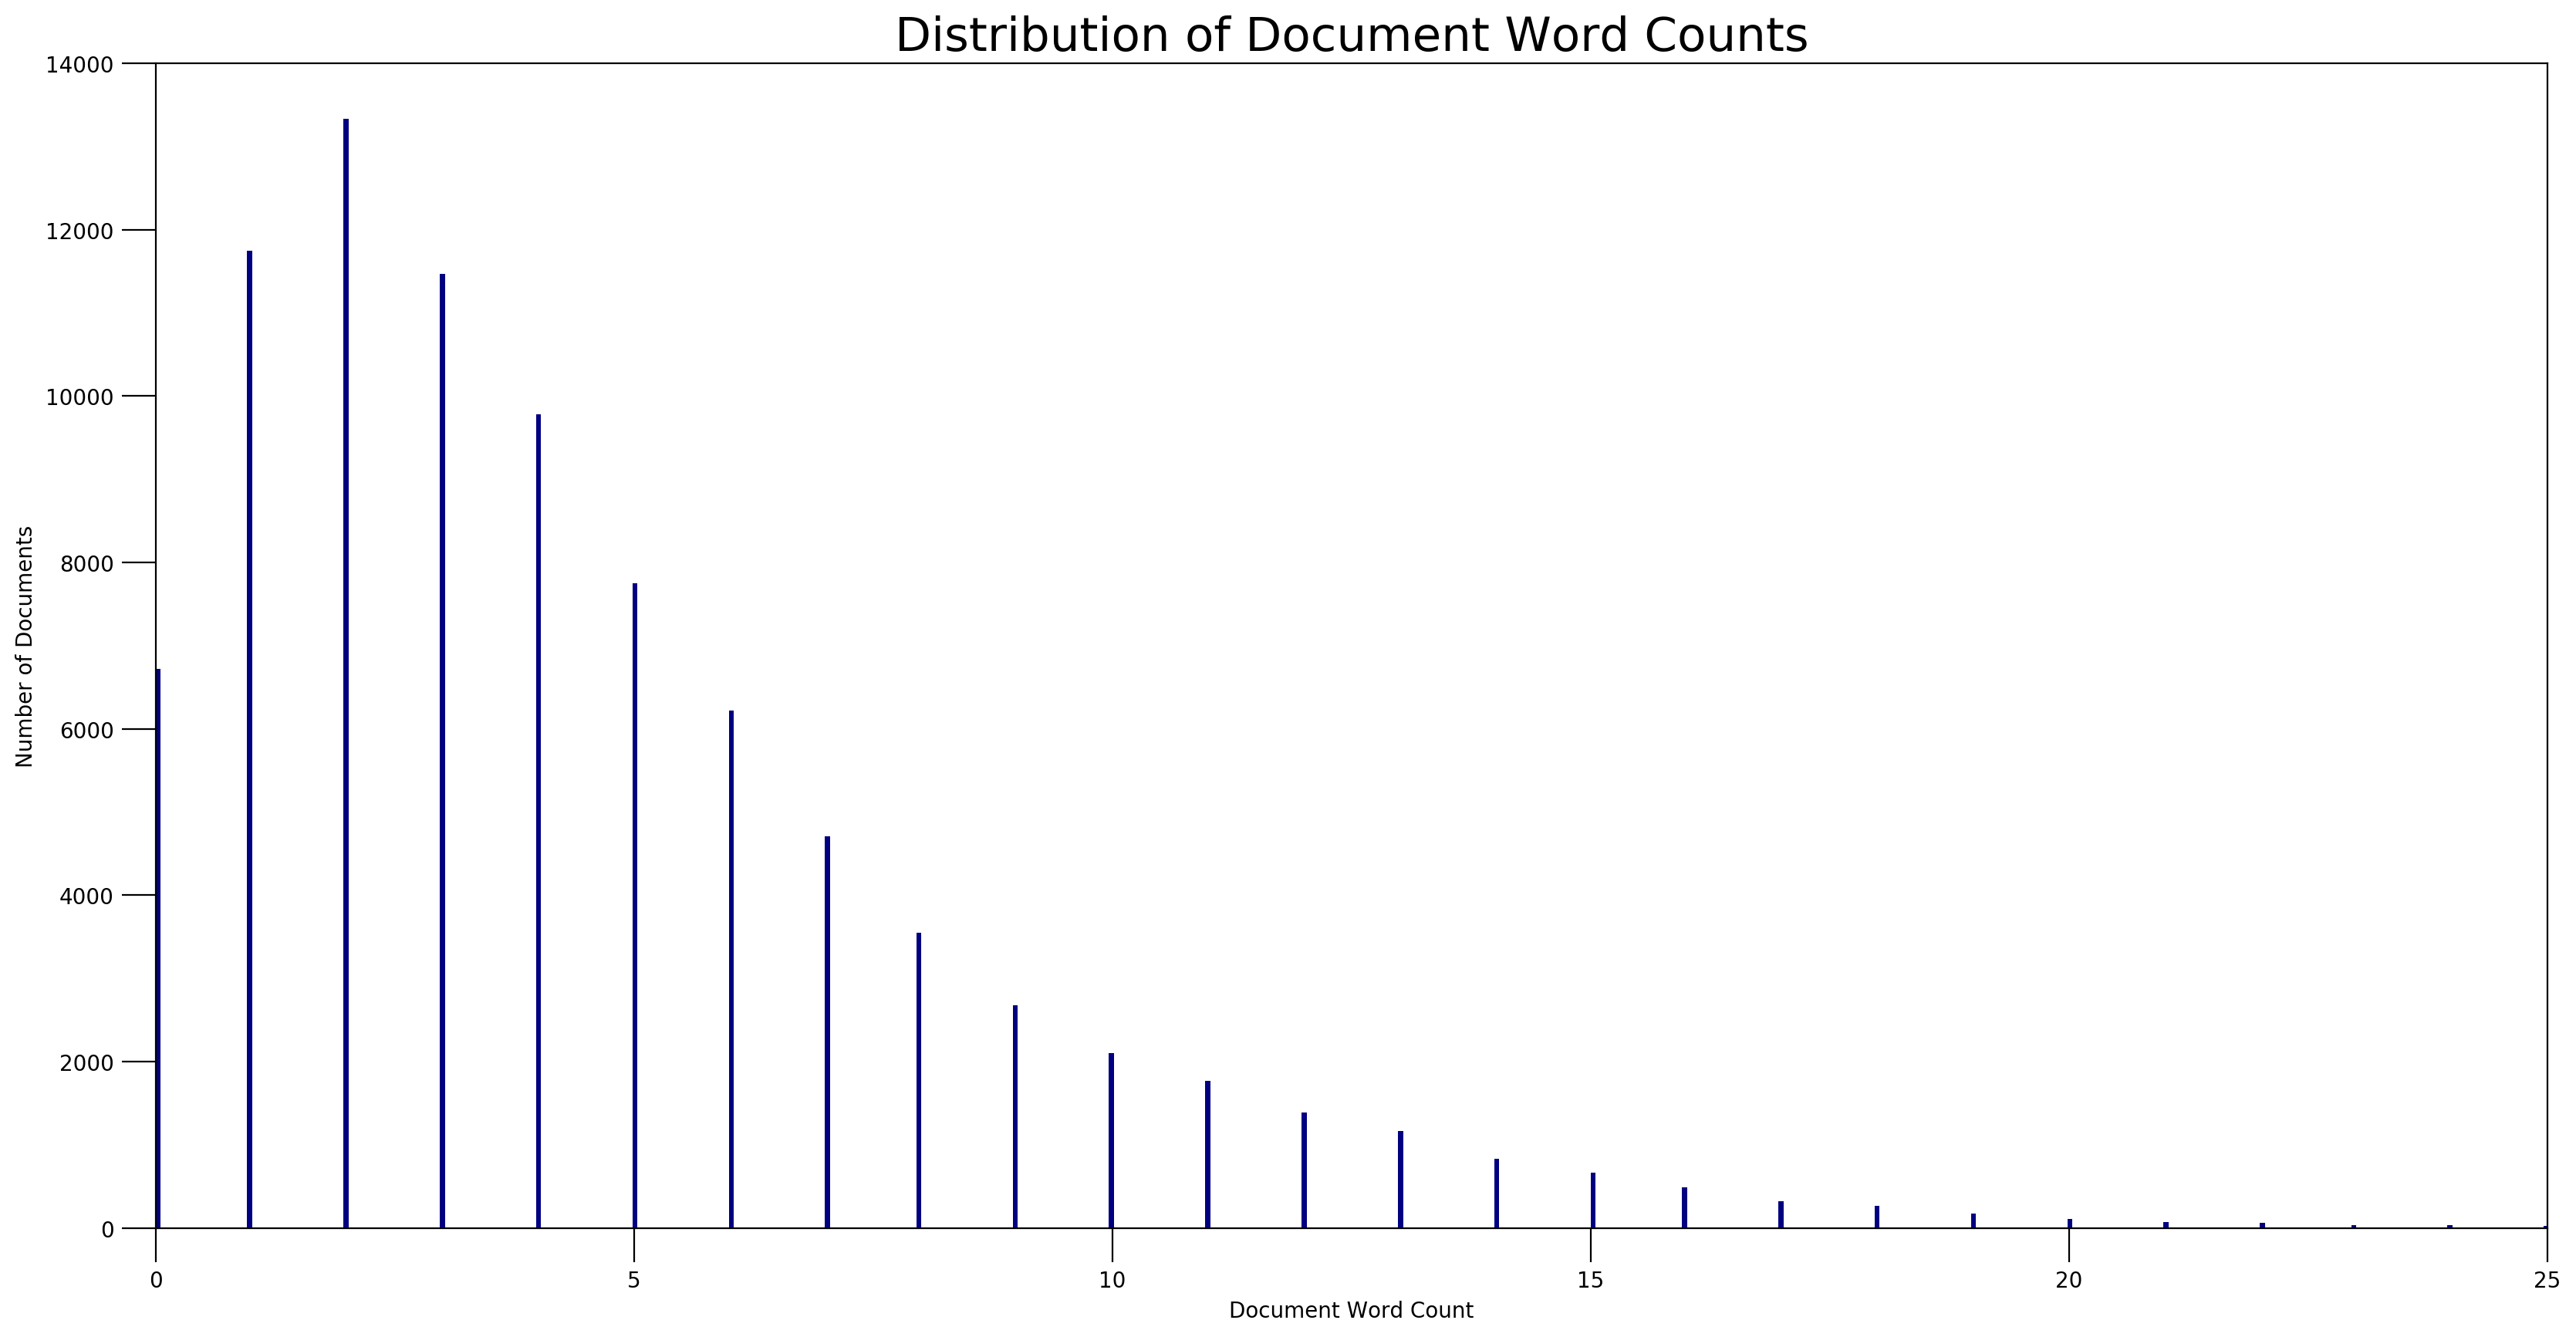

In [19]:
# Plot
plt.figure(figsize=(20,10), dpi=200)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.gca().set(xlim=(0, 25), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

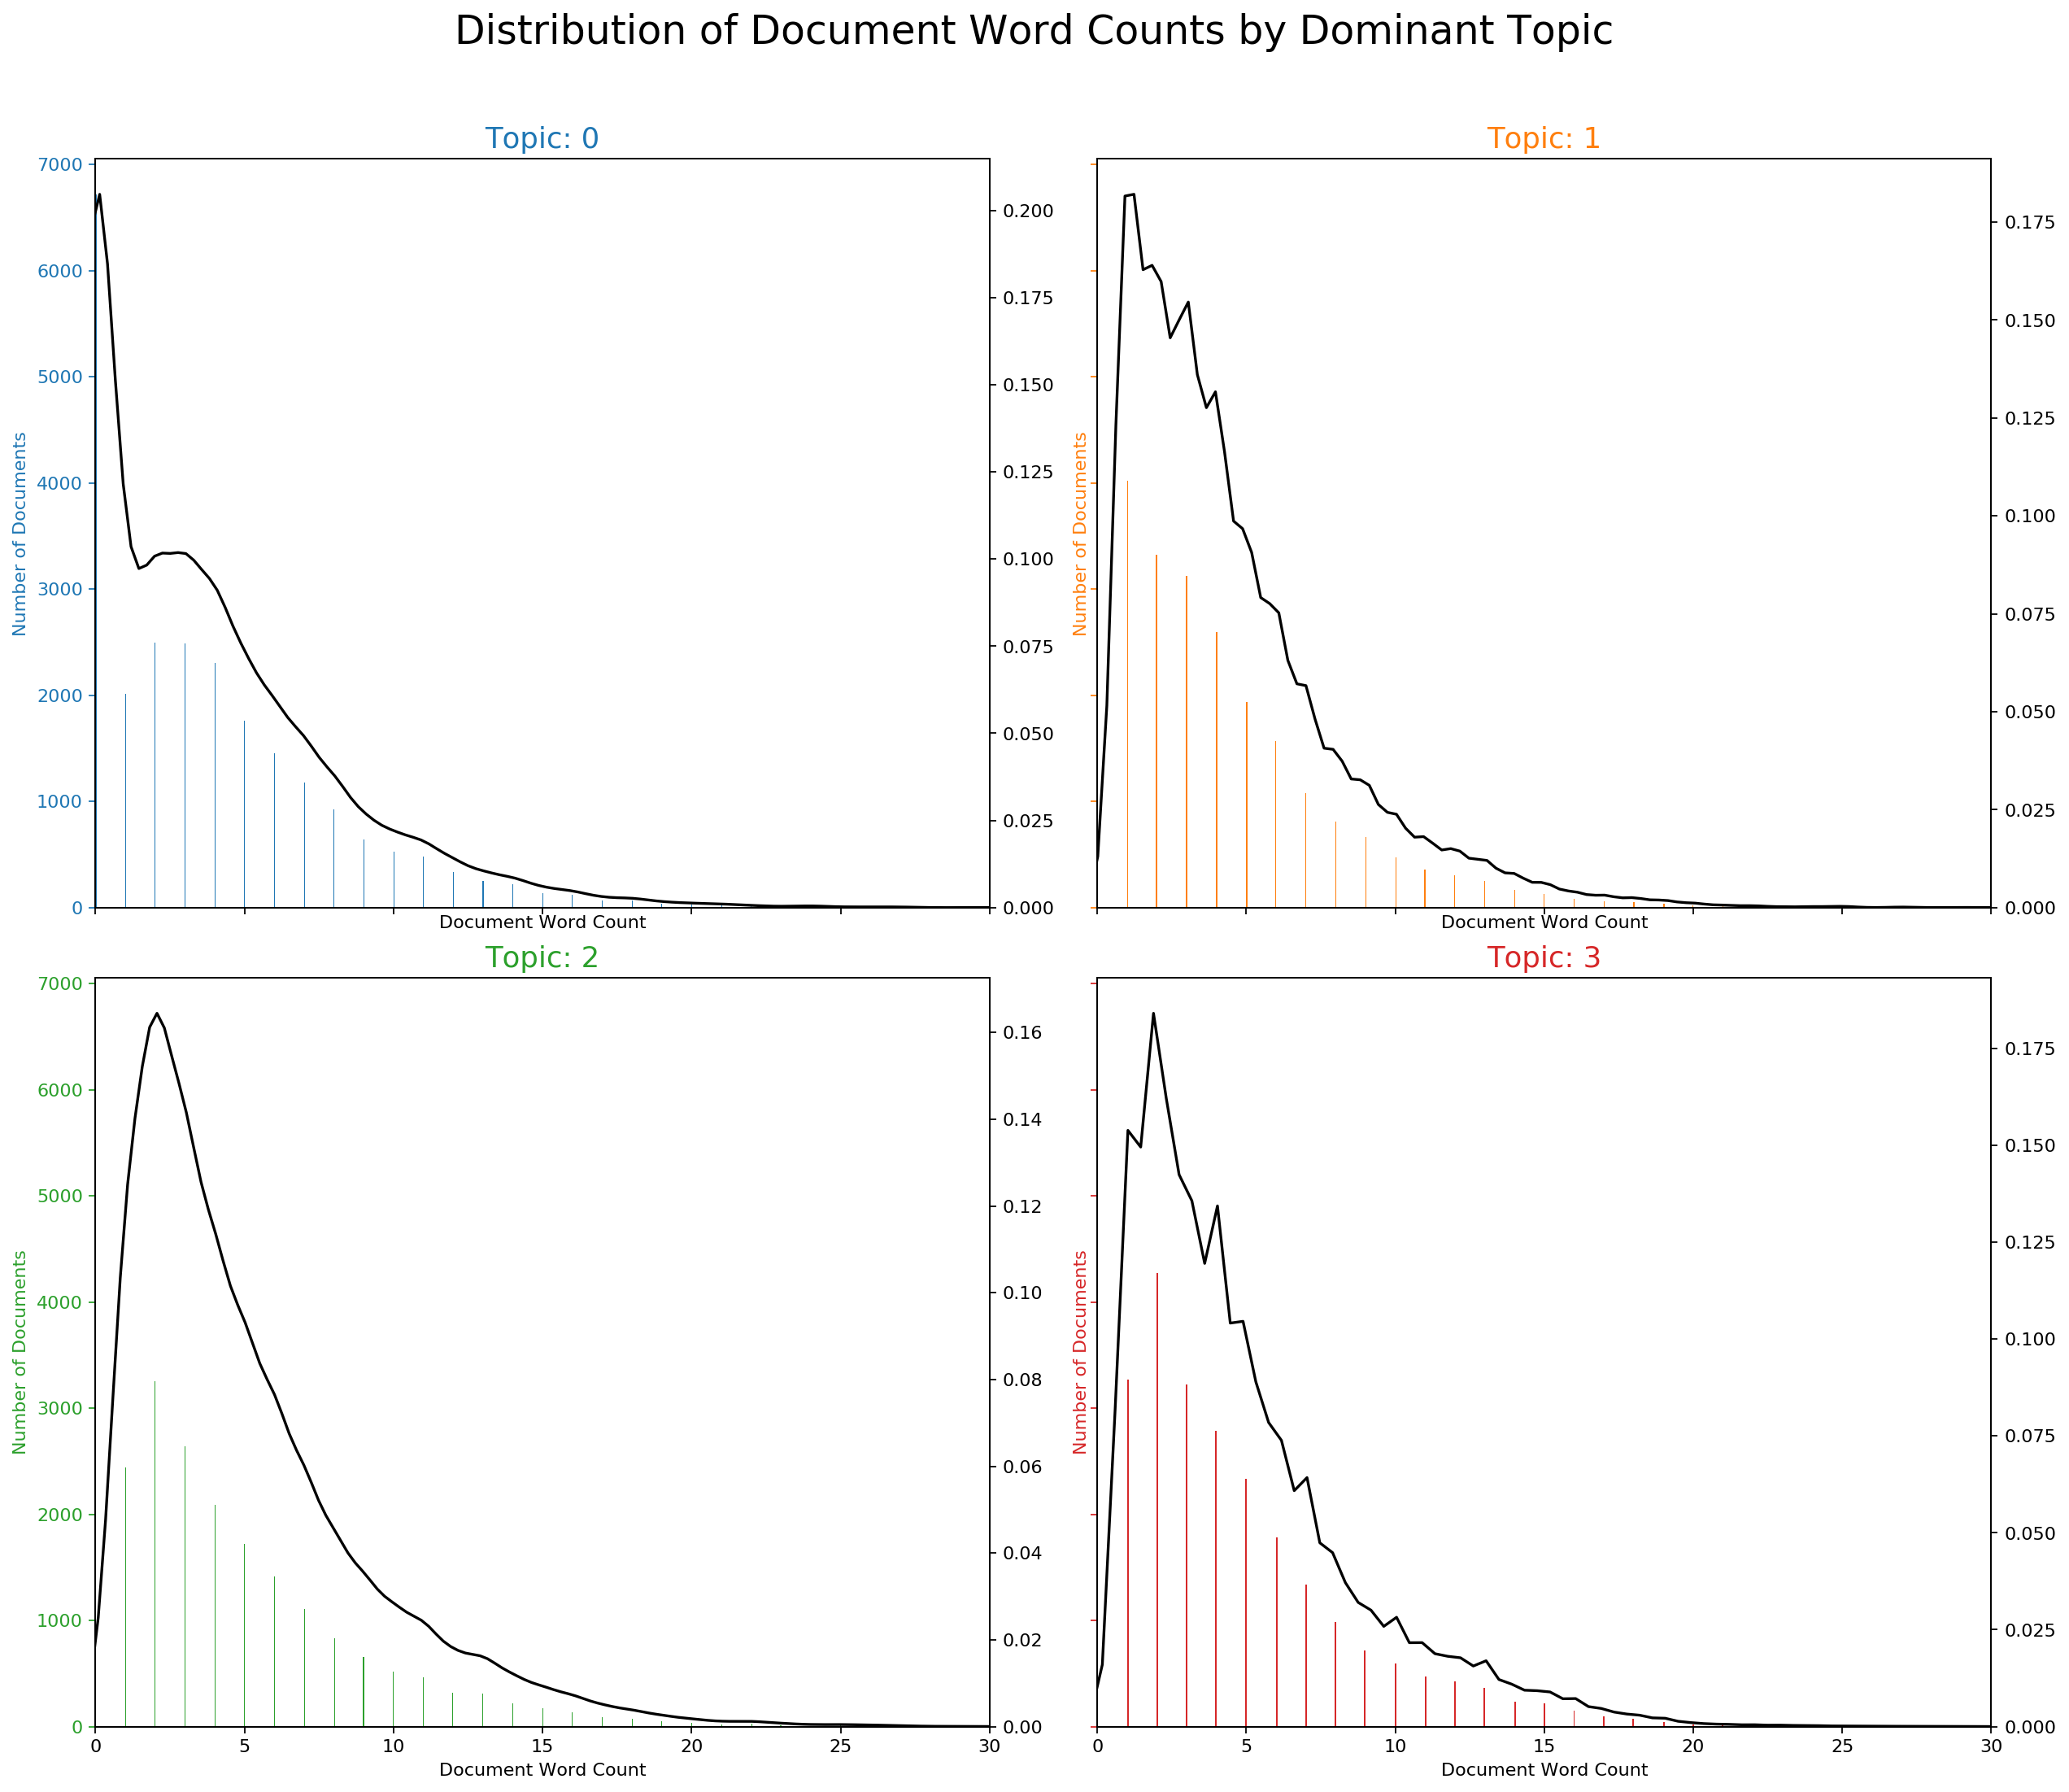

In [20]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

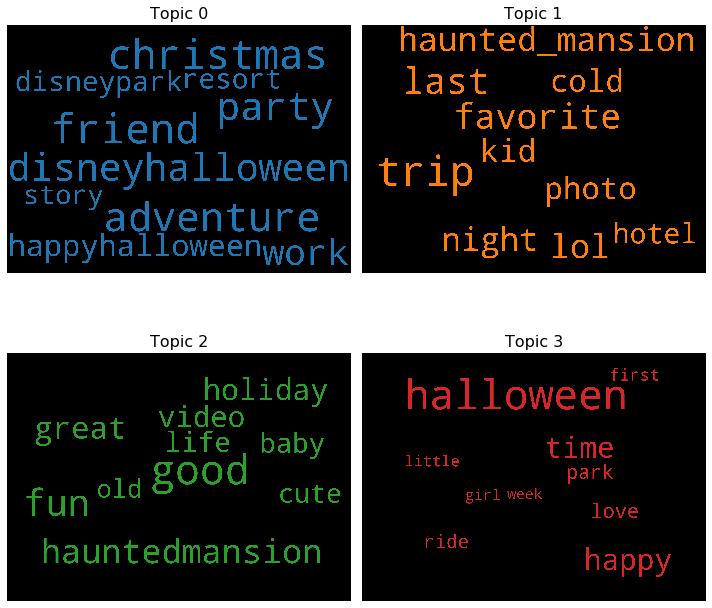

In [21]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

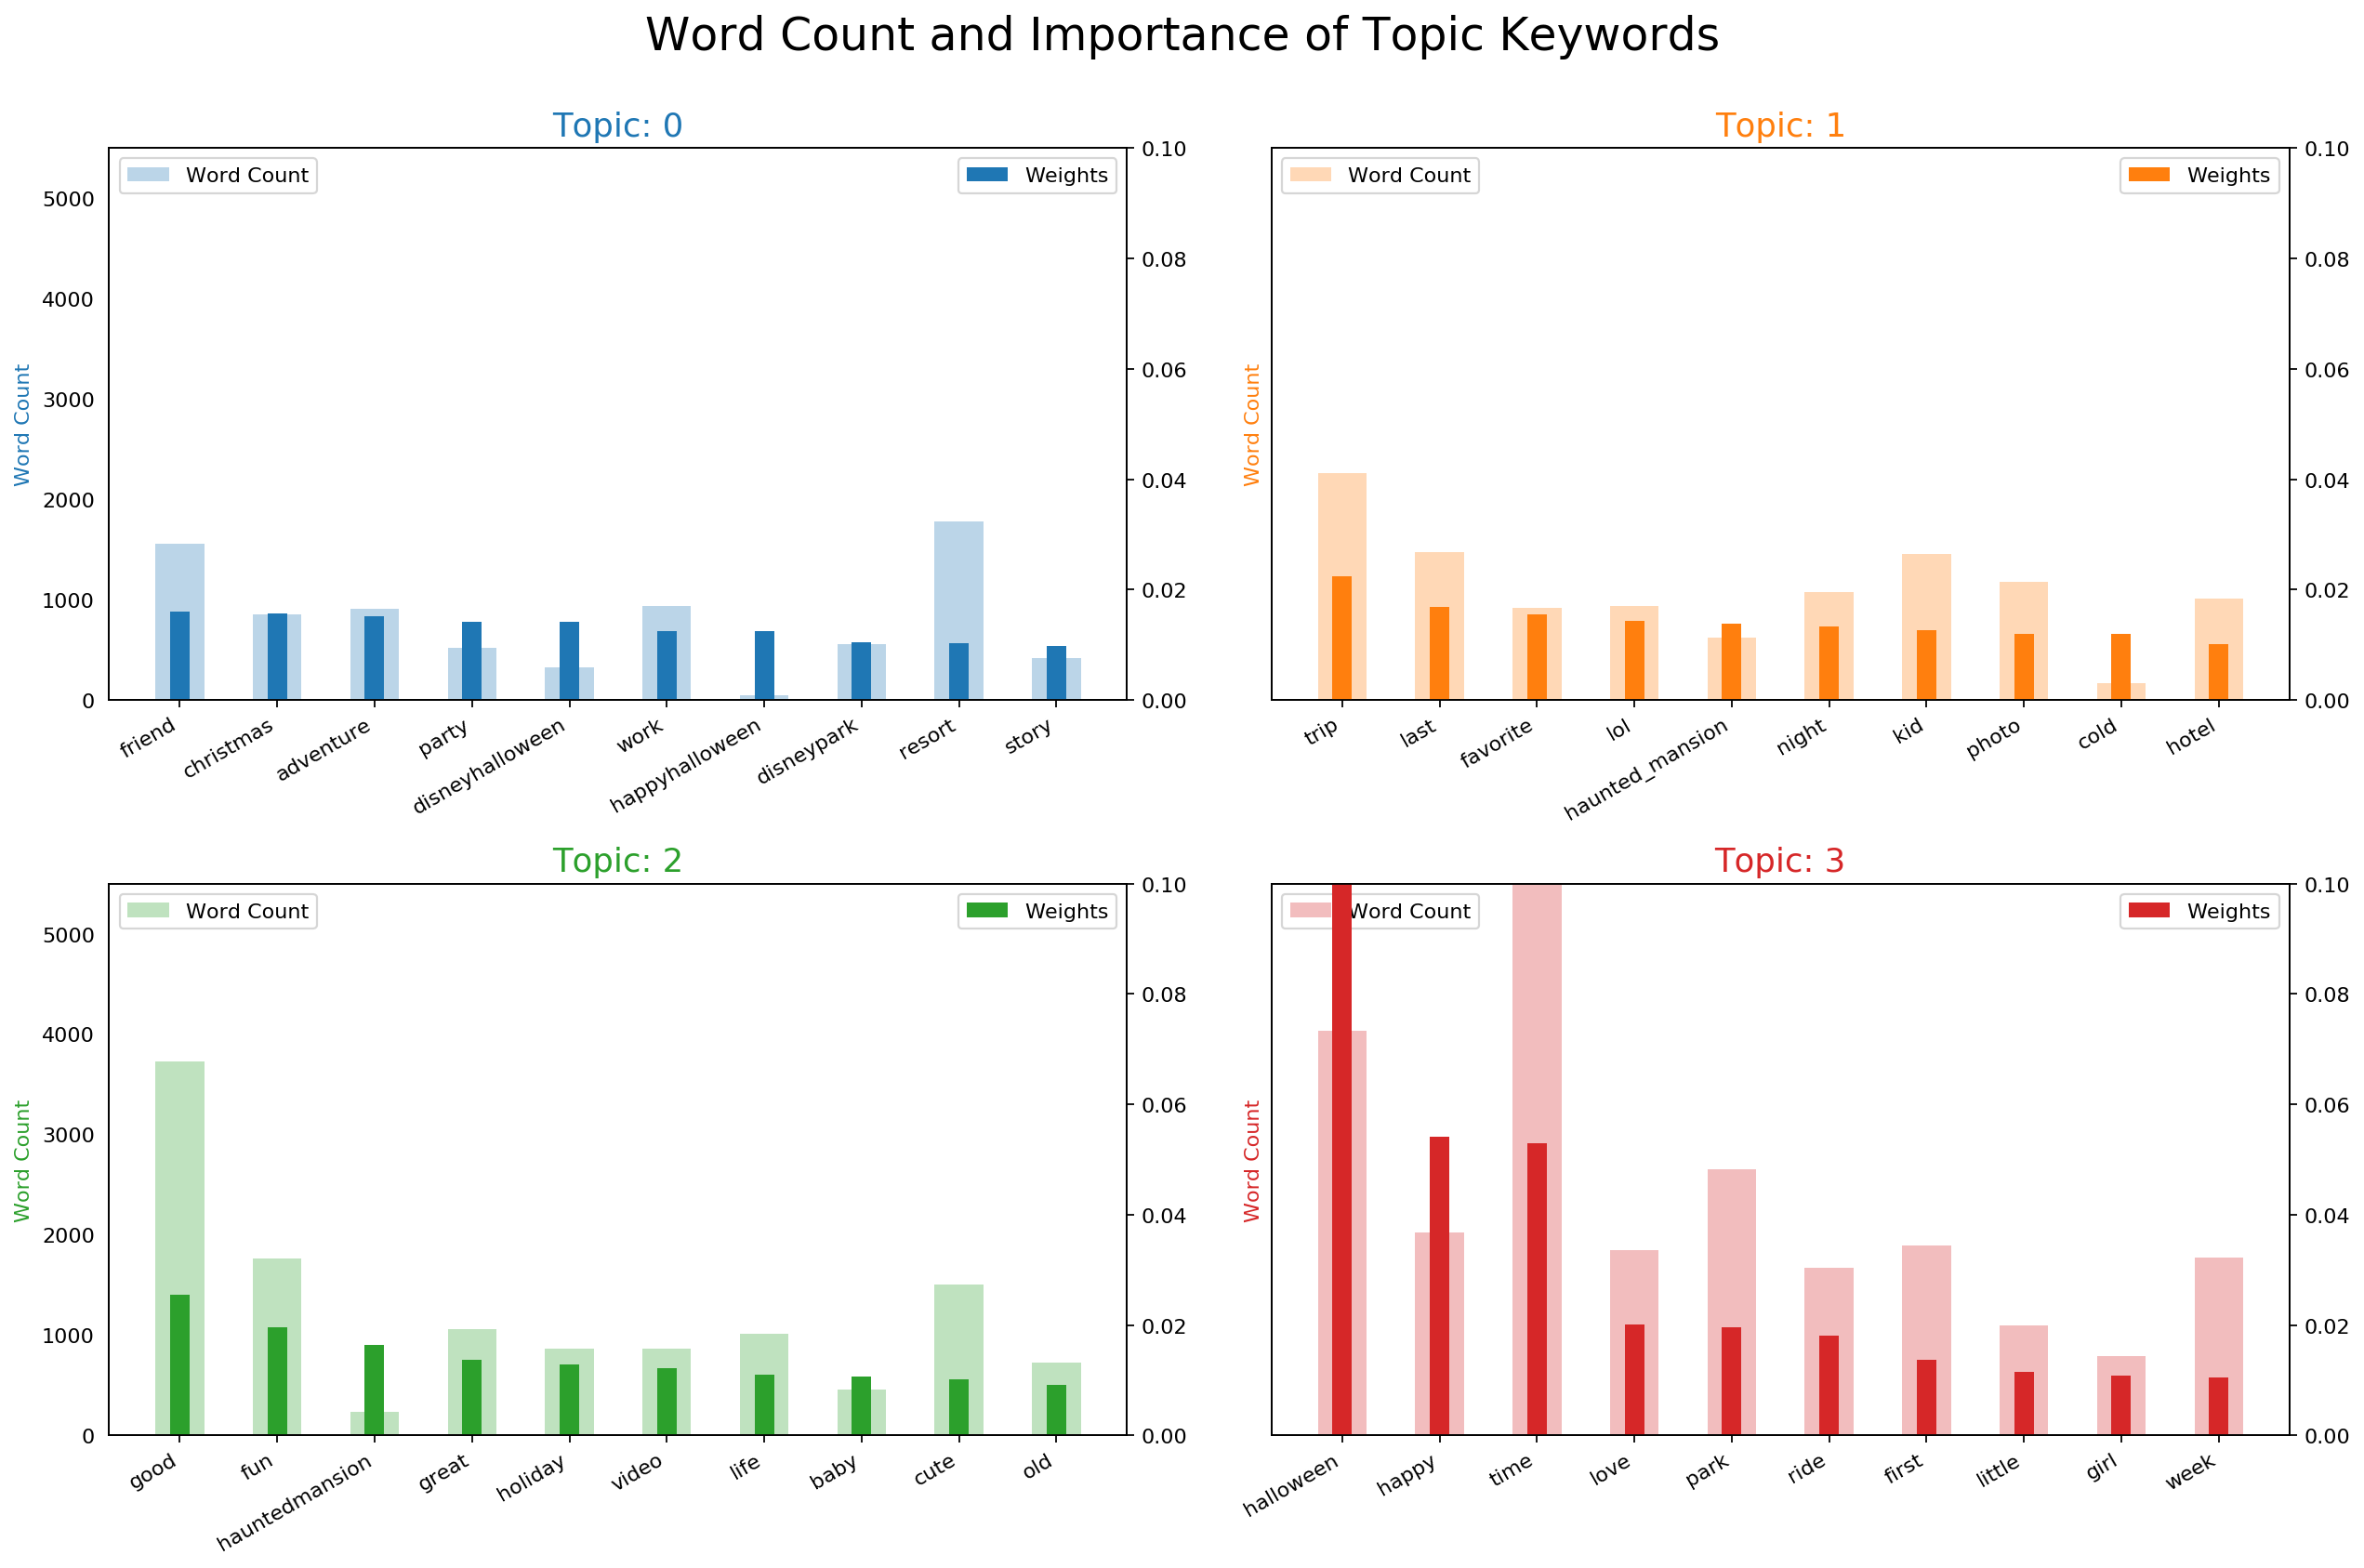

In [22]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 5500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

/Users/justin/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12511 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/justin/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12483 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/justin/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12461 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/justin/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/justin/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12459 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/justin/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_

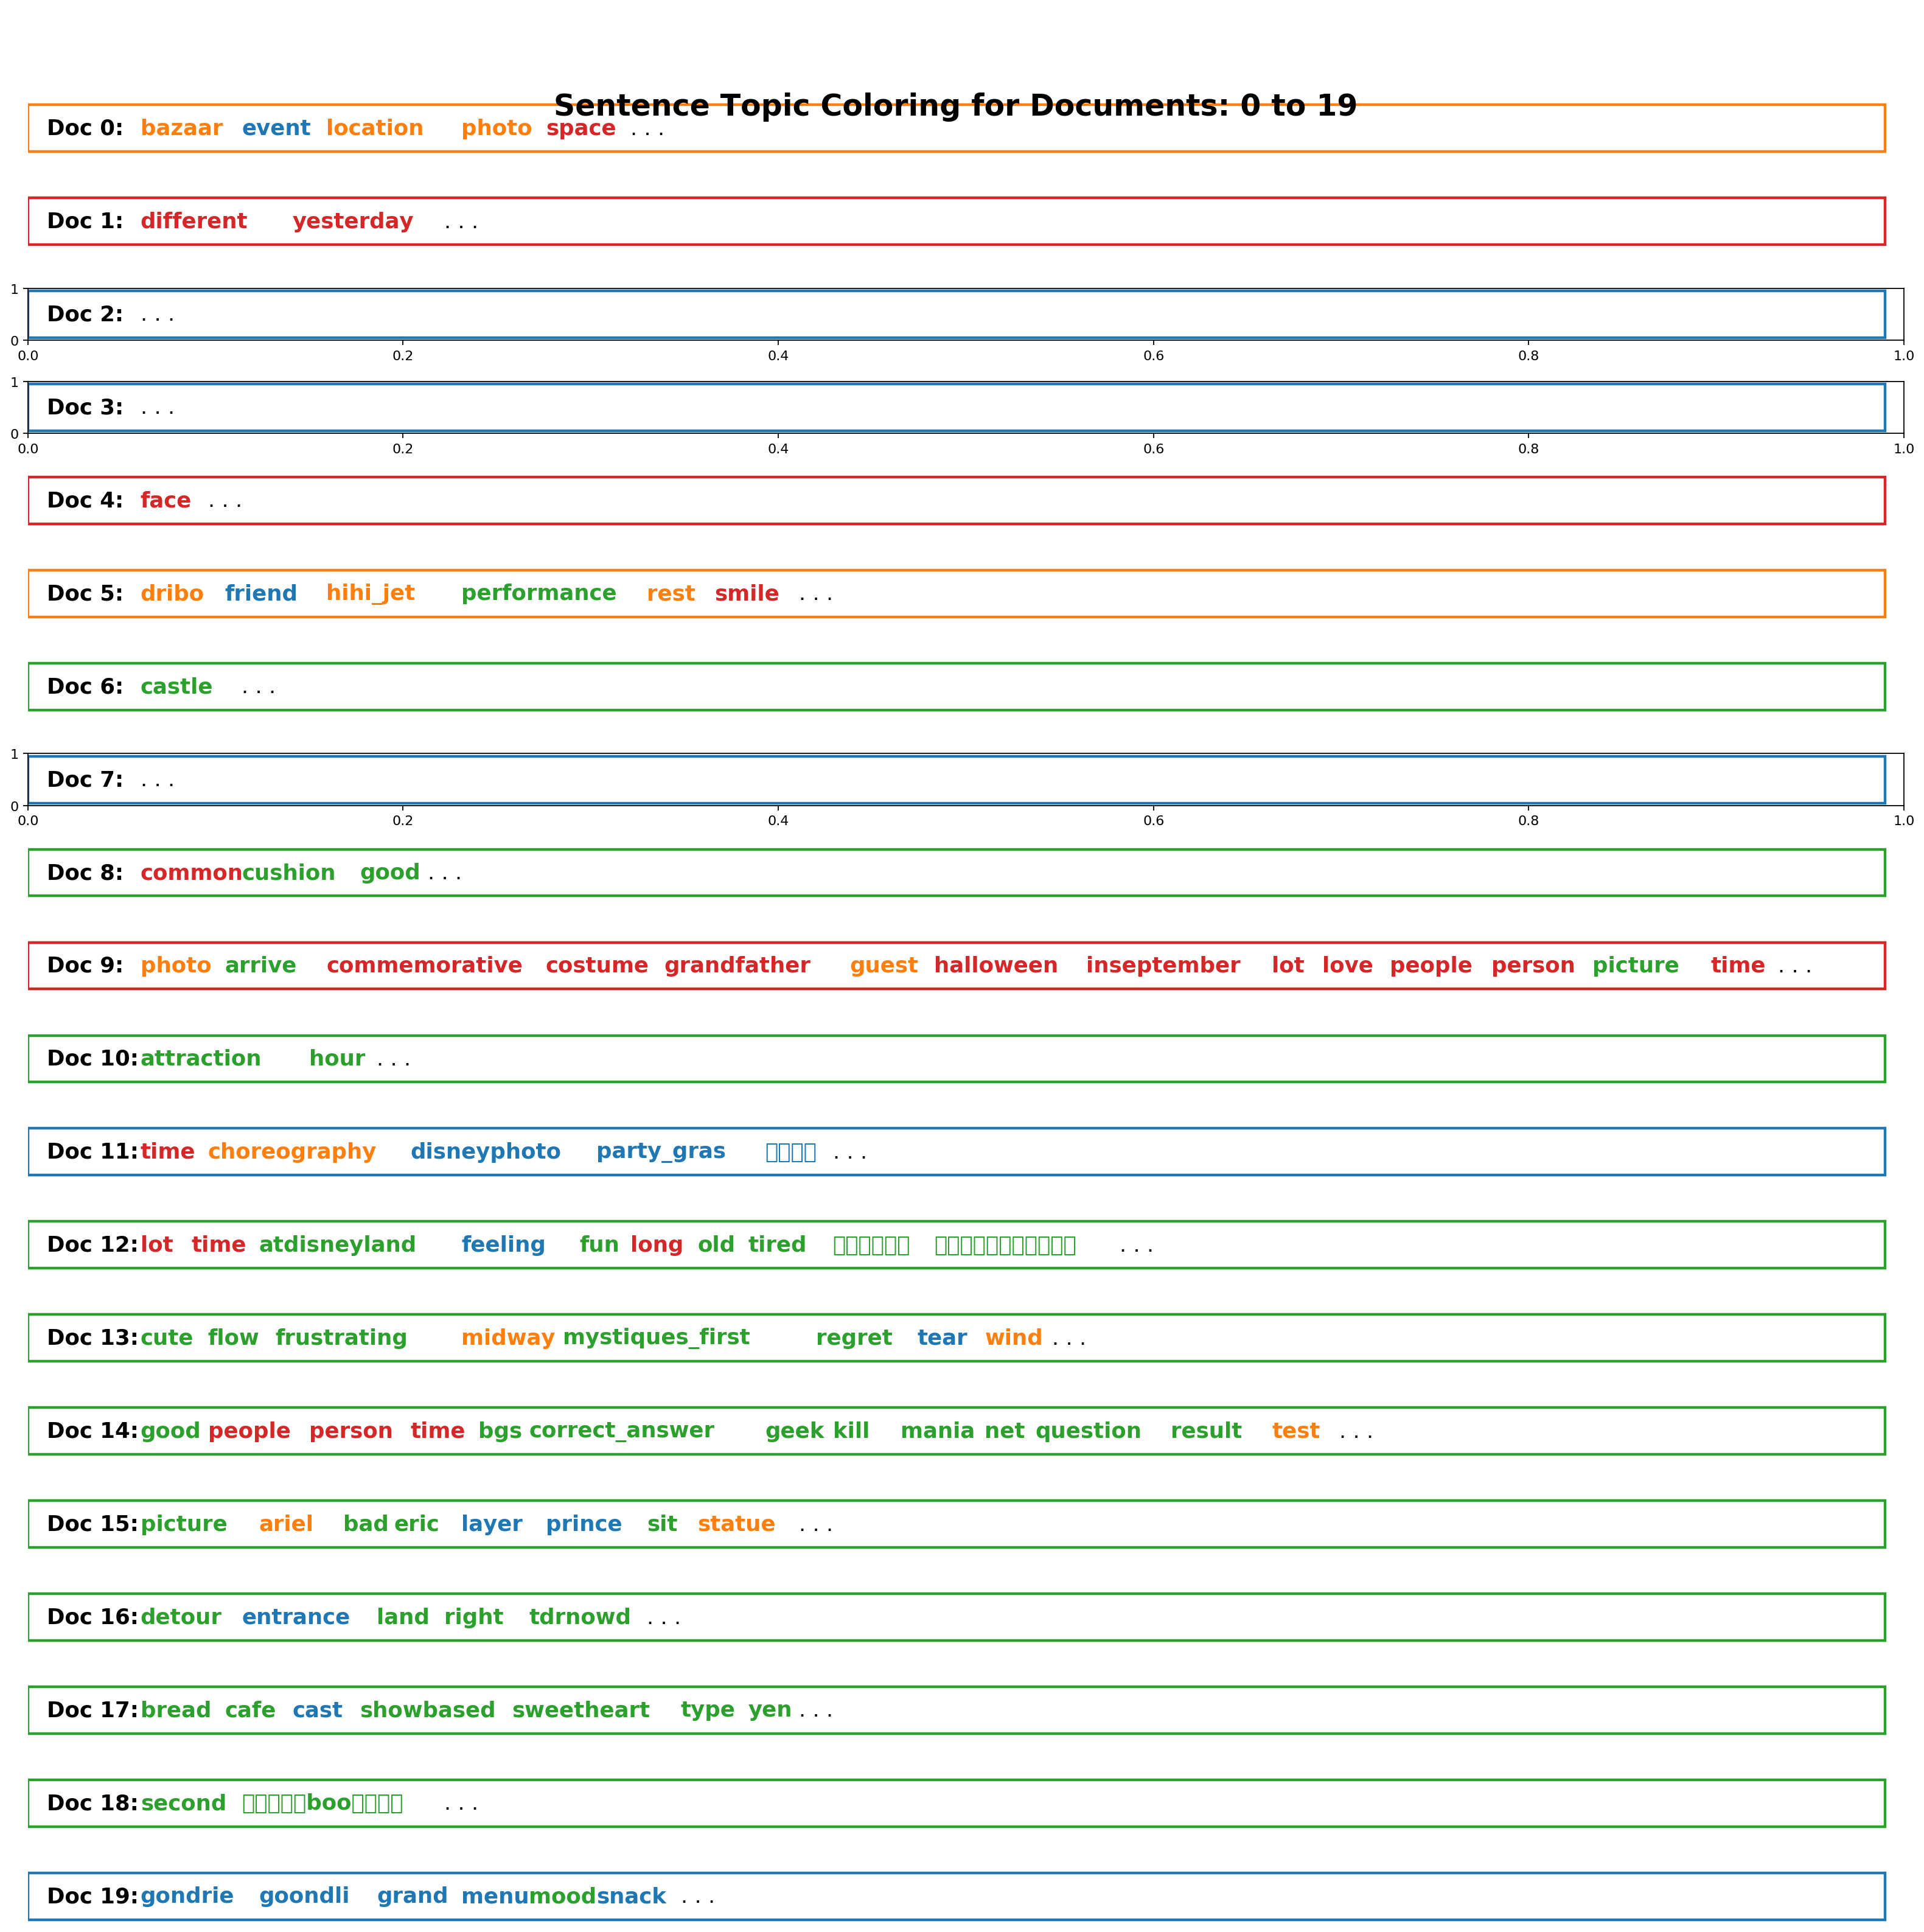

In [23]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 21):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [24]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

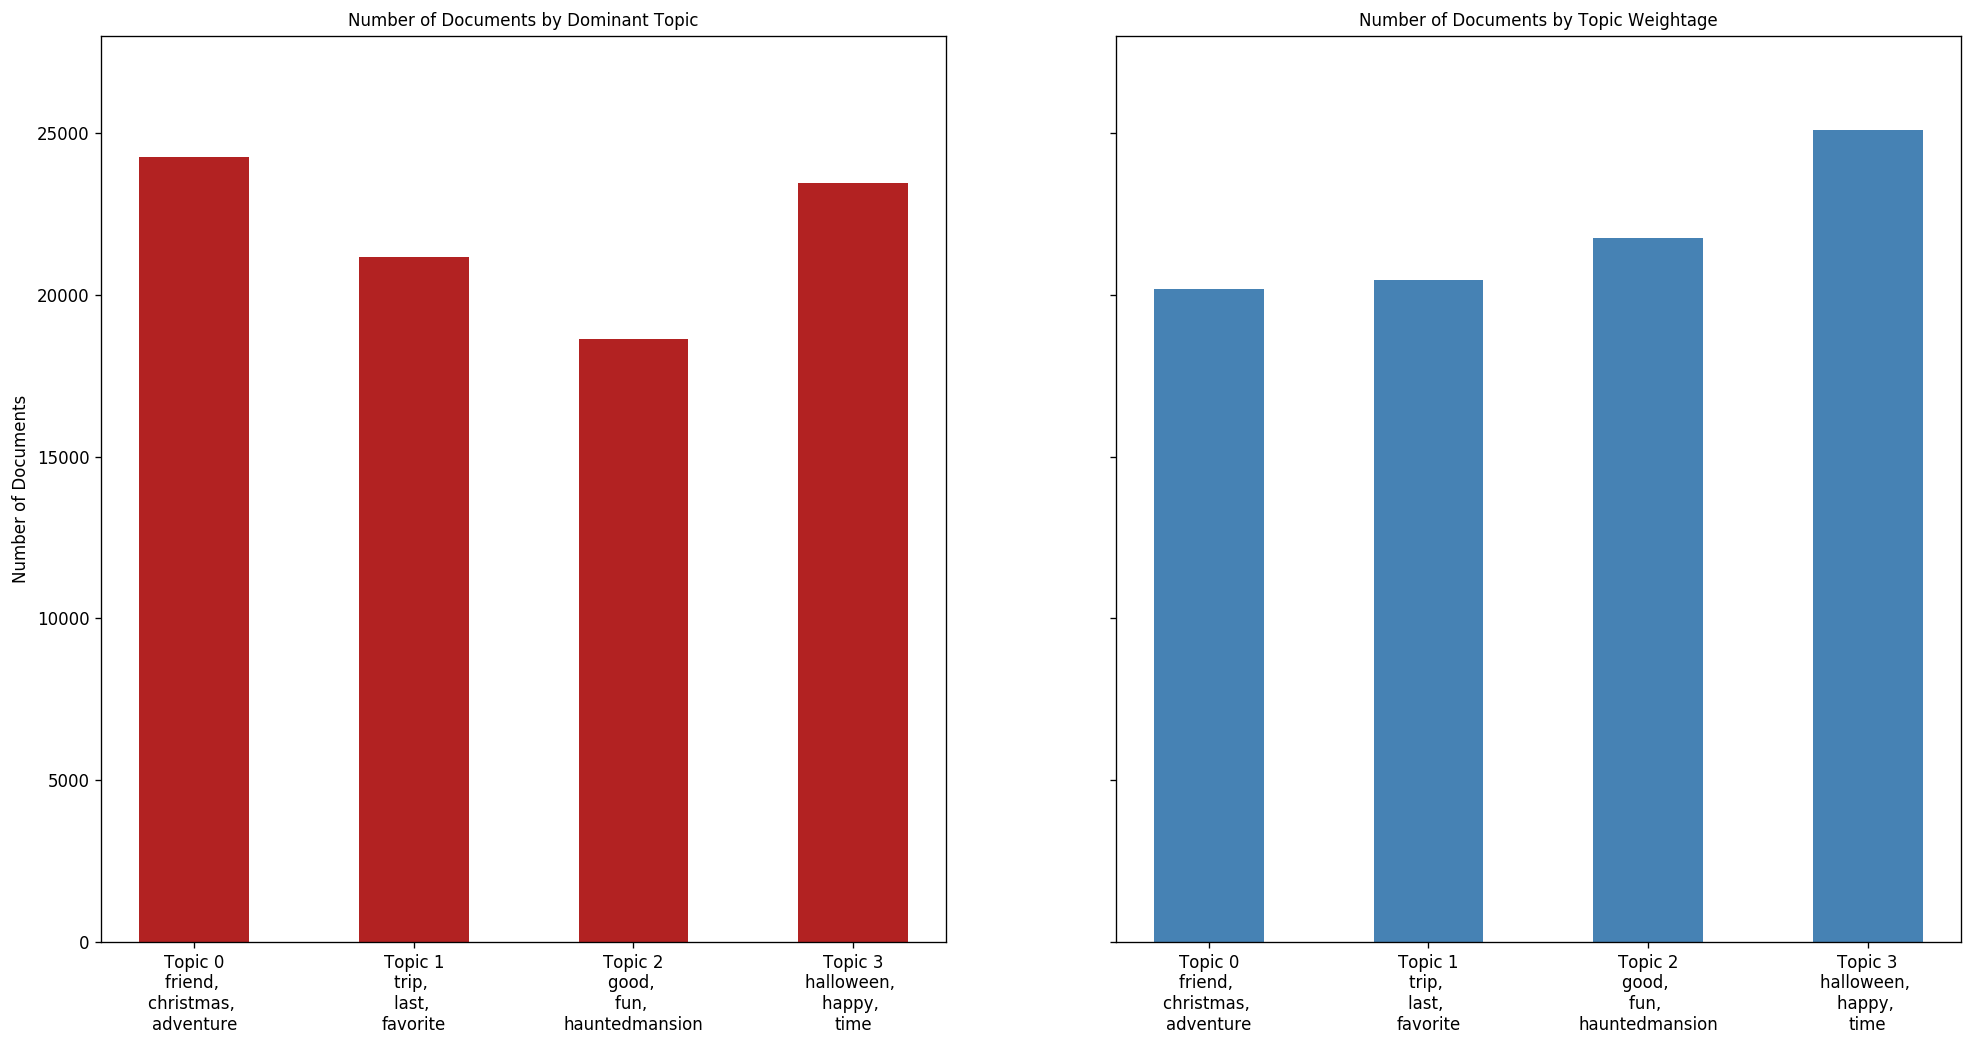

In [25]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 28000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [26]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state= 77, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 72889 samples in 0.027s...
[t-SNE] Computed neighbors for 72889 samples in 1.199s...
[t-SNE] Computed conditional probabilities for sample 1000 / 72889
[t-SNE] Computed conditional probabilities for sample 2000 / 72889
[t-SNE] Computed conditional probabilities for sample 3000 / 72889
[t-SNE] Computed conditional probabilities for sample 4000 / 72889
[t-SNE] Computed conditional probabilities for sample 5000 / 72889
[t-SNE] Computed conditional probabilities for sample 6000 / 72889
[t-SNE] Computed conditional probabilities for sample 7000 / 72889
[t-SNE] Computed conditional probabilities for sample 8000 / 72889
[t-SNE] Computed conditional probabilities for sample 9000 / 72889
[t-SNE] Computed conditional probabilities for sample 10000 / 72889
[t-SNE] Computed conditional probabilities for sample 11000 / 72889
[t-SNE] Computed conditional probabilities for sample 12000 / 72889
[t-SNE] Computed conditional probabilities for sam

In [27]:
# tsne_lda
# tsne_lda[:, 0]
# tsne_lda[:, 1]

In [28]:
# from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

In [31]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [32]:
num_topics = 4
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

friend               0.016
christmas            0.016
adventure            0.015
party                0.014
disneyhalloween      0.014
work                 0.012
happyhalloween       0.012
disneypark           0.011
resort               0.010
story                0.010
Topic 1 |---------------------

trip                 0.022
last                 0.017
favorite             0.015
lol                  0.014
haunted_mansion      0.014
night                0.013
kid                  0.013
photo                0.012
cold                 0.012
hotel                0.010
Topic 2 |---------------------

good                 0.025
fun                  0.020
hauntedmansion       0.016
great                0.014
holiday              0.013
video                0.012
life                 0.011
baby                 0.011
cute                 0.010
old                  0.009
Topic 3 |---------------------

halloween            0.126
hap

In [ ]:
# top_labels = {0: 'Topic 1', 1:'Topic 2', 2:'Topic 3', 3:'Topic 4'}

In [ ]:
# top_dist =[]
# for d in corpus:
#     tmp = {i:0 for i in range(num_topics)}
#     tmp.update(dict(lda_model[d]))
#     vals = list(OrderedDict(tmp).values())
#     top_dist += [array(vals)]

In [33]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700,tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave")
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

# #hover tools
# hover = plot.select(dict(type=HoverTool))
# hover.tooltips = {"content": "Title: @title, KeyWords: @content - Topic: @topic_key "}
# plot.legend.location = "top_left"

show(plot)

Loading BokehJS ...

In [34]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/justin/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.351371  0.006423       1        1  28.499895
2     -0.122245  0.279238       2        1  25.160425
0     -0.111084 -0.264638       3        1  23.599821
1     -0.118042 -0.021023       4        1  22.739864, topic_info=      Category          Freq             Term         Total  loglift  logprob
23     Default  14303.000000        halloween  14303.000000  30.0000  30.0000
407    Default   6120.000000            happy   6120.000000  29.0000  29.0000
30     Default   5989.000000             time   5989.000000  28.0000  28.0000
17     Default   2546.000000             good   2546.000000  27.0000  27.0000
1107   Default   2019.000000             trip   2019.000000  26.0000  26.0000
...        ...           ...              ...           ...      ...      ...
15096   Topic4    460.117462            bitch    460.877319   1.4794  -5.2792
15154   Topic4    439.025177  highest_waiting    439.753204   1.4794  -5.3261
390     Topic4    464.559296            front    465.348663   1.4794  -5.2696
1139    Topic4    474.305756             idea    475.140411   1.4793  -5.2489
1197    Topic4    461.811432             meet    462.647949   1.4792  -5.2755

[155 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
225       4  0.997969       adult
3780      3  0.999501   adventure
280       1  0.999483     amazing
2656      4  0.999359     anaheim
31        2  0.999294  attraction
...     ...       ...         ...
585       4  0.998990     weather
463       1  0.999583        week
2720      2  0.999136     weekend
1514      4  0.999262        well
494       3  0.999132        work

[129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])